In [1]:
import torch
from functools import partial
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt


# reproducibility
seed = 1993
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = "/home/studio-lab-user/CIL_Survey/data"


## **Load and preprocess data**

In [2]:
train_dataset_gpu = {}
eval_dataset_gpu = {}

# dataset
train = torchvision.datasets.CIFAR100(root=data_dir, download=True, transform=transforms.ToTensor())
eval = torchvision.datasets.CIFAR100(root=data_dir, train=False, transform=transforms.ToTensor())

# move dataset to gpu
train_dataset_gpu_loader = torch.utils.data.DataLoader(train, batch_size=len(train), drop_last=True,
                                            shuffle=True, num_workers=2, persistent_workers=False)
eval_dataset_gpu_loader = torch.utils.data.DataLoader(eval, batch_size=len(eval), drop_last=True,
                                            shuffle=False, num_workers=1, persistent_workers=False)
train_dataset_gpu['images'], train_dataset_gpu['targets'] = [item.to(device="cuda", non_blocking=True) for item in next(iter(train_dataset_gpu_loader))]
eval_dataset_gpu['images'],  eval_dataset_gpu['targets']  = [item.to(device="cuda", non_blocking=True) for item in next(iter(eval_dataset_gpu_loader)) ]

# normalize images
train_cifar_std, train_cifar_mean = torch.std_mean(train_dataset_gpu['images'], dim=(0, 2, 3)) 
print(f"Mean: {[f'{x:.4f}' for x in train_cifar_mean.tolist()]}")
print(f"Std: {[f'{x:.4f}' for x in train_cifar_std.tolist()]}")
def batch_normalize_images(input_images, mean, std):
    return (input_images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)
batch_normalize_images = partial(batch_normalize_images, mean=train_cifar_mean, std=train_cifar_std)
train_dataset_gpu['images'] = batch_normalize_images(train_dataset_gpu['images'])
eval_dataset_gpu['images']  = batch_normalize_images(eval_dataset_gpu['images'])

data = {
        'train': train_dataset_gpu,
        'eval': eval_dataset_gpu
    }

# pad images for later random cropping
pad_amount = 4
data['train']['images'] = F.pad(data['train']['images'], (pad_amount,)*4, 'reflect')

Files already downloaded and verified
Mean: ['0.5071', '0.4865', '0.4409']
Std: ['0.2673', '0.2564', '0.2762']


## **Load Model**

In [3]:
from convs.cifar_resnet import resnet32

# model 
# net = resnet32()
# net = IncrementalNet("resnet32", pretrained=False)
net = torchvision.models.resnet18()
net.to(device);  

## **Data trasnformations**

In [4]:
# transforms are:
# random crop
# random horizontal flip
# random jitter

## This is actually (I believe) a pretty clean implementation of how to do something like this, since shifted-square masks unique to each depth-channel can actually be rather
## tricky in practice. That said, if there's a better way, please do feel free to submit it! This can be one of the harder parts of the code to understand (though I personally get
## stuck on the fold/unfold process for the lower-level convolution calculations.
def make_random_square_masks(inputs, mask_size):
    ##### TODO: Double check that this properly covers the whole range of values. :'( :')
    if mask_size == 0:
        return None # no need to cutout or do anything like that since the patch_size is set to 0
    is_even = int(mask_size % 2 == 0)
    in_shape = inputs.shape

    # seed centers of squares to cutout boxes from, in one dimension each
    mask_center_y = torch.empty(in_shape[0], dtype=torch.long, device=inputs.device).random_(mask_size//2-is_even, in_shape[-2]-mask_size//2-is_even)
    mask_center_x = torch.empty(in_shape[0], dtype=torch.long, device=inputs.device).random_(mask_size//2-is_even, in_shape[-1]-mask_size//2-is_even)

    # measure distance, using the center as a reference point
    to_mask_y_dists = torch.arange(in_shape[-2], device=inputs.device).view(1, 1, in_shape[-2], 1) - mask_center_y.view(-1, 1, 1, 1)
    to_mask_x_dists = torch.arange(in_shape[-1], device=inputs.device).view(1, 1, 1, in_shape[-1]) - mask_center_x.view(-1, 1, 1, 1)

    to_mask_y = (to_mask_y_dists >= (-(mask_size // 2) + is_even)) * (to_mask_y_dists <= mask_size // 2)
    to_mask_x = (to_mask_x_dists >= (-(mask_size // 2) + is_even)) * (to_mask_x_dists <= mask_size // 2)

    final_mask = to_mask_y * to_mask_x ## Turn (y by 1) and (x by 1) boolean masks into (y by x) masks through multiplication. Their intersection is square, hurray! :D

    return final_mask

def batch_crop(inputs, crop_size):
    with torch.no_grad():
        crop_mask_batch = make_random_square_masks(inputs, crop_size)
        cropped_batch = torch.masked_select(inputs, crop_mask_batch).view(inputs.shape[0], inputs.shape[1], crop_size, crop_size)
        return cropped_batch

def batch_flip_lr(batch_images, flip_chance=.5):
    with torch.no_grad():
        # TODO: Is there a more elegant way to do this? :') :'((((
        return torch.where(torch.rand_like(batch_images[:, 0, 0, 0].view(-1, 1, 1, 1)) < flip_chance, torch.flip(batch_images, (-1,)), batch_images)

@torch.no_grad()
def get_batches(data_dict, key, batchsize, indices, cutmix=False, cutmix_size=None):
    # select subset of class indices 
    if indices is not None:
        indices = torch.tensor(indices, device=device)
        images, targets = data_dict[key]["images"], data_dict[key]["targets"] 
        samples = torch.isin(targets, indices)
        images, targets = images[samples], targets[samples]
        assert len(images) == len(targets)

    num_epoch_examples = len(images)
    shuffled = torch.randperm(num_epoch_examples, device=device)
    crop_size = 32

    ## Here, we prep the dataset by applying all data augmentations in batches ahead of time before each epoch, then we return an iterator below
    ## that iterates in chunks over with a random derangement (i.e. shuffled indices) of the individual examples. So we get perfectly-shuffled
    ## batches (which skip the last batch if it's not a full batch), but everything seems to be (and hopefully is! :D) properly shuffled. :)
    if key == 'train':
        images = batch_crop(images, crop_size) # TODO: hardcoded image size for now?
        images = batch_flip_lr(images)
        if cutmix:
            images, targets = batch_cutmix(images, targets, patch_size=cutmix_size)

    # # Send the images to an (in beta) channels_last to help improve tensor core occupancy (and reduce NCHW <-> NHWC thrash) during training
    # images = images.to(memory_format=torch.channels_last)
    for idx in range(num_epoch_examples // batchsize):
        if not (idx+1)*batchsize > num_epoch_examples: ## Use the shuffled randperm to assemble individual items into a minibatch
            yield images.index_select(0, shuffled[idx*batchsize:(idx+1)*batchsize]), \
                  targets.index_select(0, shuffled[idx*batchsize:(idx+1)*batchsize]) ## Each item is only used/accessed by the network once per epoch. :D


## **Training and evaluation**

In [5]:
# training
def train(optimizer, first_task=True):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    # pbar = tqdm(total=2500, desc="Train", unit="img", ncols=100)
    for batch_idx, (inputs, targets) in enumerate(get_batches(data, "train", batch_size, indices=range(current_classes, current_classes + increment))):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets) if first_task else criterion(outputs[:, current_classes:], targets - current_classes)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += len(targets)
        correct += predicted.eq(targets).sum().item()

        # pbar.update(len(inputs))
    # pbar.set_postfix({"Train Loss": train_loss/(batch_idx+1), "Train Acc": 100.*correct/total})
    # pbar.close()
    return train_loss/(batch_idx + 1), 100.*correct/total


def eval():
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    # pbar = tqdm(total=500, desc="Eval", unit="img", ncols=100)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(get_batches(data, "eval", batch_size, indices=range(current_classes + increment))):
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += len(targets)
            correct += predicted.eq(targets).sum().item()

            # pbar.update(len(inputs))
        # pbar.set_postfix({"Eval Loss": test_loss/(batch_idx+1), "Eval Acc": 100.*correct/total})
        # pbar.close()

    return test_loss/(batch_idx + 1), 100.*correct/total


def incremental_train():
    # update linear classifier
    new_fc = nn.Linear(feature_dim, current_classes + increment, device="cuda")
    nn.init.kaiming_uniform_(new_fc.weight, nonlinearity='linear')
    nn.init.constant_(new_fc.bias, 0)
    if current_classes != 0:
        old_fc = net.fc
        new_fc.weight.data[:current_classes] = old_fc.weight
        new_fc.bias.data[:current_classes] = old_fc.bias
    net.fc = new_fc

    # select optimize and scheduler
    if current_classes == 0:
        epochs = init_epochs
        optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=init_lr, weight_decay=init_weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    else: 
        epochs = rest_epochs
        optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=rest_lr, weight_decay=rest_weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=rest_milestones, gamma=rest_lr_decay)

    pbar = tqdm(range(epochs), unit="epoch", position=1)
    pbar.set_description(f"Task [{(current_classes + increment) // 5}/{20}]")
    for epoch in pbar:
        tloss, tacc = train(optimizer, first_task=current_classes == 0)
        eloss, eacc = eval()
        scheduler.step()

        # metrics 
        if epoch == epochs - 1:
            tlosses.append(tloss)
            taccs.append(tacc)
            elosses.append(eloss)
            eaccs.append(eacc)
        pbar.set_postfix({"Train Loss": tloss, "Train Acc": tacc, "Eval Loss": eloss, "Eval Acc": eacc})


tlosses, taccs = [], []
elosses, eaccs = [], []


criterion = nn.CrossEntropyLoss()
increment = 5
total_classes = 100 
current_classes = 0 
feature_dim = 512
batch_size = 128

# optimizer and scheduler config
init_epochs = 200
init_lr = 0.1
init_weight_decay = 0.0005

rest_epochs = 80
rest_lr = 0.1
rest_weight_decay = 2e-4
rest_milestones = [40, 70]
rest_lr_decay = 0.1


pbar2 = tqdm(range(total_classes // increment), position=0)
for i in pbar2:
    incremental_train()
    current_classes += increment

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [19:09<00:00, 57.49s/it]


## **Results**

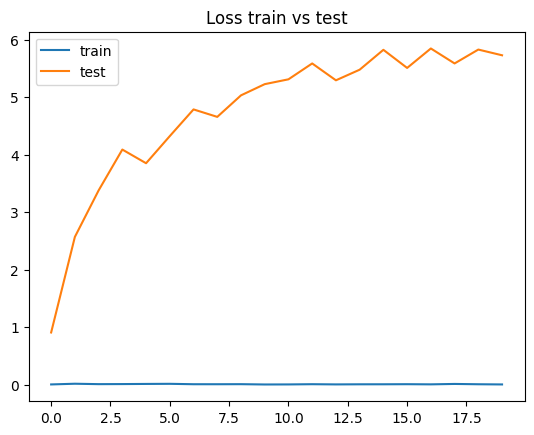

In [6]:
plt.plot(tlosses, label="train")
plt.plot(elosses, label="test")
plt.title("Loss train vs test")
plt.legend()
plt.plot();

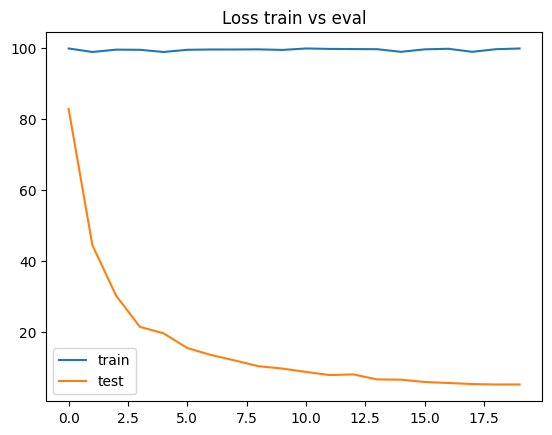

In [7]:
plt.plot(taccs, label="train")
plt.plot(eaccs, label="test")
plt.title("Loss train vs eval")
plt.legend()
plt.plot();